# Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv

In [2]:
DATA_DIR = '/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv'
data = pd.read_csv(DATA_DIR)

In [3]:
# Convert date columns to datetime where possible
for col in ['INFODT', 'EXAMDT', 'ORIG_ENTRY', 'LAST_UPDATE']:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')

# Convert specific date columns
data['EXAMDT'] = pd.to_datetime(data['EXAMDT'], errors='coerce')
data['INFODT'] = pd.to_datetime(data['INFODT'], errors='coerce')

# Fallback: fill missing EXAMDT with INFODT
data['EXAMDT'] = data['EXAMDT'].fillna(data['INFODT'])

print("Earliest visit:", data['EXAMDT'].min())
print("Latest visit:", data['EXAMDT'].max())
print("Median interval between visits (days):", 
      data.sort_values(['PATNO', 'EXAMDT']).groupby('PATNO')['EXAMDT'].diff().median())


#Check outliers or wrong values
np3_cols = [col for col in data.columns if col.startswith('NP3') and col != 'NP3TOT']

# Find out-of-range values
out_of_range = (data[np3_cols] < 0) | (data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    display(data.loc[out_of_range.any(axis=1), ['PATNO', 'EXAMDT'] + np3_cols])
else:
    print("All NP3 scores within expected range (0–4). Ignored values in the NP3TOT column.")

Earliest visit: 2010-07-01 00:00:00
Latest visit: 2025-03-01 00:00:00
Median interval between visits (days): 181 days 00:00:00


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/1986860071.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/1986860071.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/1986860071.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')


,PATNO,EXAMDT,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,...,NP3PTRMR,NP3PTRML,NP3KTRMR,NP3KTRML,NP3RTARU,NP3RTALU,NP3RTARL,NP3RTALL,NP3RTALJ,NP3RTCON
62,3002,2022-03-01,2.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,3003,2022-04-01,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,3009,2024-07-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,3010,2022-11-01,3.0,2.0,101.0,101.0,101.0,101.0,101.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,3010,2023-12-01,3.0,2.0,101.0,101.0,101.0,101.0,101.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32212,349772,2025-02-01,0.0,0.0,101.0,101.0,101.0,101.0,101.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32246,359738,2024-09-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32247,359738,2025-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32259,366799,2025-01-01,0.0,0.0,101.0,101.0,101.0,101.0,101.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Replace 101 values with NaN in NP3 columns
np3_cols = [col for col in data.columns if col.startswith('NP3') and col != 'NP3TOT']
data[np3_cols] = data[np3_cols].replace(101, np.nan)
# Also replace 101 in NHY column with NaN
data['NHY'] = data['NHY'].replace(101, np.nan)


# Find out-of-range values
out_of_range = (data[np3_cols] < 0) | (data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    display(data.loc[out_of_range.any(axis=1), ['PATNO', 'EXAMDT'] + np3_cols])
else:
    print("All NP3 scores within expected range (0–4). Ignored NP3TOT.")

print(f"Remaining rows after filtering NP3TOT: {len(data)}")


All NP3 scores within expected range (0–4). Ignored NP3TOT.
Remaining rows after filtering NP3TOT: 32346


In [5]:
# Drop rows where NP3TOT is NaN
data = data.dropna(subset=['NP3TOT'])
print(f"Remaining rows after dropping NaN NP3TOT: {len(data)}")


Remaining rows after dropping NaN NP3TOT: 26109


# Exploratory Data Analysis / # Data Analysis

Visualize and quantify missingness across key variables using heatmaps and summary statistics.

Summarize the dataset structure, check column meanings, and display initial rows to understand the data.

In [6]:
# Sort by PATNO and visit date (prefer EXAMDT, fallback to INFODT)
if 'EXAMDT' in data.columns:
    data = data.sort_values(['PATNO', 'EXAMDT'])
elif 'INFODT' in data.columns:
    data = data.sort_values(['PATNO', 'INFODT'])

# Remove post-baseline visits with EXAMDT on or before baseline for each patient
if 'EXAMDT' in data.columns and 'PATNO' in data.columns:
    baseline_dates = data.groupby('PATNO')['EXAMDT'].transform('min')
    # Keep only visits after baseline or the baseline itself
    mask = (data['EXAMDT'] > baseline_dates) | (data['EXAMDT'] == baseline_dates)
    n_before = data.shape[0]
    data = data[mask]
    n_after = data.shape[0]
    print(f"Removed {n_before - n_after} visits with EXAMDT on or before baseline (except baseline itself).")

assert pd.api.types.is_datetime64_any_dtype(data['EXAMDT'])

# Create a visit number per patient
data['VISIT_NUM'] = data.groupby('PATNO').cumcount()

# Show a summary
print(data[['PATNO', 'EXAMDT', 'EVENT_ID', 'PDSTATE', 'NP3TOT', 'VISIT_NUM']].head(10))

Removed 0 visits with EXAMDT on or before baseline (except baseline itself).
    PATNO     EXAMDT EVENT_ID PDSTATE  NP3TOT  VISIT_NUM
0    3000 2011-02-01       BL     NaN     4.0          0
1    3000 2012-03-01      V04     NaN     1.0          1
2    3000 2013-02-01      V06     NaN     4.0          2
3    3000 2014-03-01      V08     NaN     2.0          3
4    3000 2015-03-01      V10     NaN    19.0          4
5    3000 2016-04-01      V12     NaN     3.0          5
6    3000 2018-02-01      V14     NaN    10.0          6
7    3000 2019-03-01      V15     NaN     5.0          7
8    3000 2021-05-01      V17     NaN     3.0          8
10   3001 2011-02-01       SC     NaN    18.0          0


In [7]:
# Check visit intervals (in days) for a sample patient
sample_patno = data['PATNO'].dropna().unique()[0]
sample = data[data['PATNO'] == sample_patno].sort_values('EXAMDT')
if sample['EXAMDT'].notna().sum() > 1:
    sample['VISIT_DIFF_DAYS'] = sample['EXAMDT'].diff().dt.days
    print(sample[['PATNO', 'EXAMDT', 'VISIT_DIFF_DAYS']])

   PATNO     EXAMDT  VISIT_DIFF_DAYS
0   3000 2011-02-01              NaN
1   3000 2012-03-01            394.0
2   3000 2013-02-01            337.0
3   3000 2014-03-01            393.0
4   3000 2015-03-01            365.0
5   3000 2016-04-01            397.0
6   3000 2018-02-01            671.0
7   3000 2019-03-01            393.0
8   3000 2021-05-01            792.0


In [8]:
# Check for paired ON/OFF visits (same PATNO, EVENT_ID, different PDSTATE)
paired = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].nunique()
paired_onoff = paired[paired > 1]
print("Number of ON/OFF paired visits:", paired_onoff.count())

Number of ON/OFF paired visits: 3573


Descriptive statistics:
              NP3TOT           NHY       NP3SPCH      NP3FACXP       NP3RIGN  \
count  26109.000000  26096.000000  26109.000000  26109.000000  26109.000000   
mean      16.869126      1.210799      0.465395      0.849899      0.582673   
std       14.683221      0.992777      0.668630      0.865489      0.830761   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        4.000000      0.000000      0.000000      0.000000      0.000000   
50%       15.000000      2.000000      0.000000      1.000000      0.000000   
75%       26.000000      2.000000      1.000000      1.000000      1.000000   
max      100.000000      5.000000      4.000000      4.000000      4.000000   

            NP3GAIT      NP3BRADY  
count  26109.000000  26109.000000  
mean       0.614386      0.893179  
std        0.714158      0.927159  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        1.000000      1.000000  
75%        

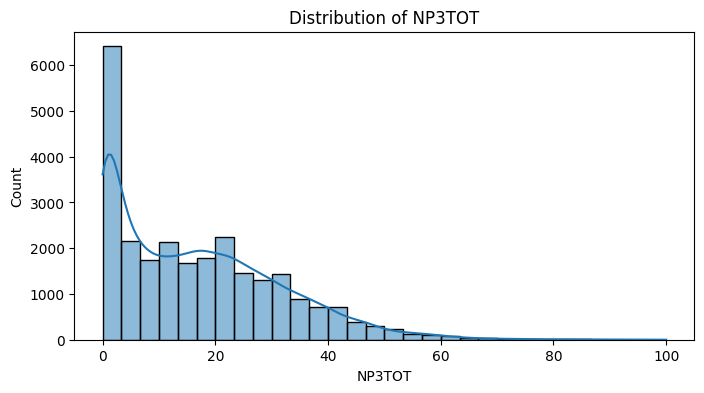

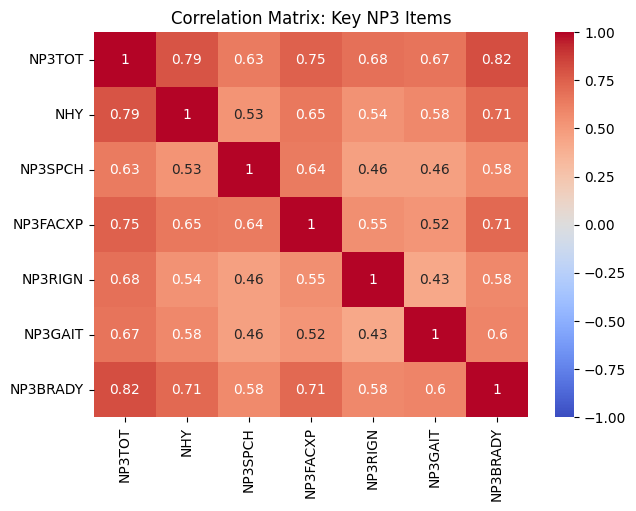

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Descriptive statistics for NP3TOT, NHY, and key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
desc = data[key_items].describe()
print("Descriptive statistics:\n", desc)

# Plot: Distribution of NP3TOT
plt.figure(figsize=(8, 4))
sns.histplot(data['NP3TOT'].dropna(), bins=30, kde=True)
plt.title('Distribution of NP3TOT')
plt.xlabel('NP3TOT')
plt.ylabel('Count')
plt.show()

# Plot: Correlation heatmap for key NP3 items
corr_matrix = data[key_items].corr()
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key NP3 Items')
plt.show()

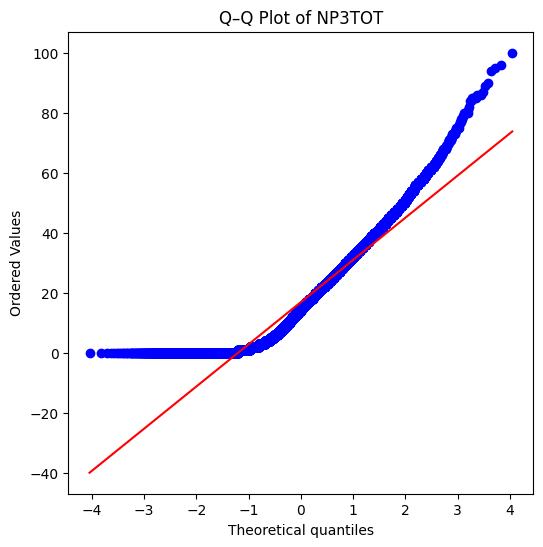

Shapiro–Wilk test for NP3TOT: W=0.919, p=6.71e-78
NP3TOT is NOT normally distributed (reject H0 at α=0.05).


/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26109.
  res = hypotest_fun_out(*samples, **kwds)


In [10]:
from scipy.stats import shapiro
import scipy.stats as stats
import matplotlib.pyplot as plt

# Q–Q plot for NP3TOT
plt.figure(figsize=(6, 6))
stats.probplot(data['NP3TOT'].dropna(), dist="norm", plot=plt)
plt.title('Q–Q Plot of NP3TOT')
plt.show()

# Shapiro–Wilk test
stat, p = shapiro(data['NP3TOT'].dropna())
print(f"Shapiro–Wilk test for NP3TOT: W={stat:.3f}, p={p:.3g}")
if p < 0.05:
    print("NP3TOT is NOT normally distributed (reject H0 at α=0.05).")
else:
    print("NP3TOT is consistent with normality (fail to reject H0 at α=0.05).")

NP3TOT: Shapiro-Wilk p-value = 0.00000


/Users/larsheijnen/Thesis/venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26109.
  res = hypotest_fun_out(*samples, **kwds)


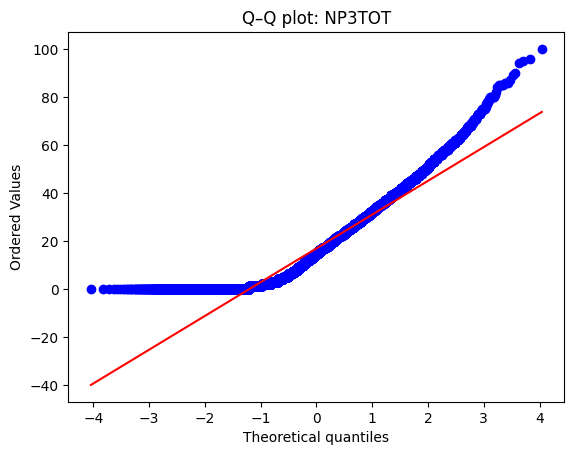

NP3TOT_log: Shapiro-Wilk p-value = 0.00000


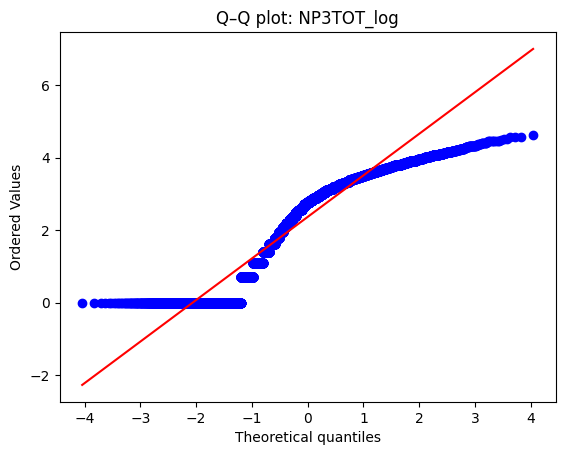

NP3TOT_sqrt: Shapiro-Wilk p-value = 0.00000


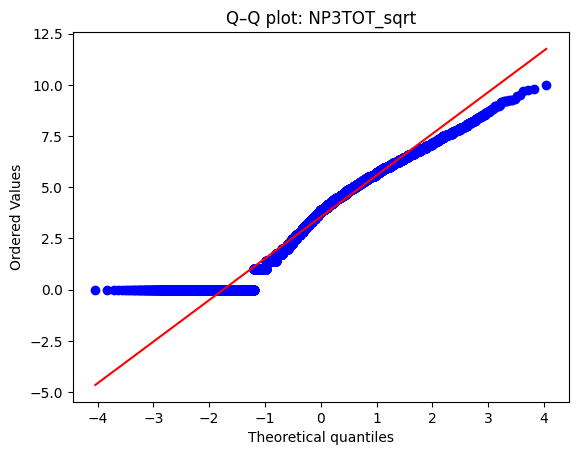

In [46]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Transformation: Shift to avoid log(0)
data['NP3TOT_log'] = np.log1p(data['NP3TOT'])  # log(1 + x)
data['NP3TOT_sqrt'] = np.sqrt(data['NP3TOT'])

# Check normality again
for col in ['NP3TOT', 'NP3TOT_log', 'NP3TOT_sqrt']:
    stat, p = stats.shapiro(data[col].dropna())
    print(f"{col}: Shapiro-Wilk p-value = {p:.5f}")

    stats.probplot(data[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q–Q plot: {col}")
    plt.show()

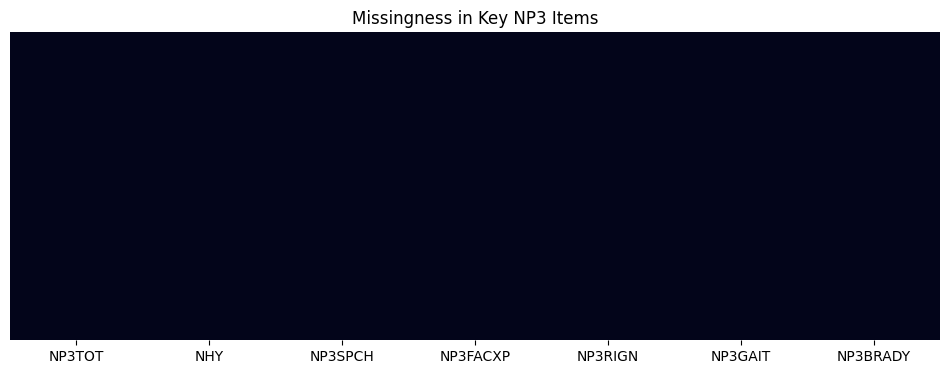


% of patients with ≥1 missing value in each key item:
          % patients with ≥1 missing
NP3TOT                           0.0
NHY                              0.3
NP3SPCH                          0.0
NP3FACXP                         0.0
NP3RIGN                          0.0
NP3GAIT                          0.0
NP3BRADY                         0.0


In [11]:
# 4. Visualize missingness (heatmap)
plt.figure(figsize=(12, 4))
sns.heatmap(data[key_items].isnull(), cbar=False, yticklabels=False)
plt.title('Missingness in Key NP3 Items')
plt.show()

missing_patients = {}
for col in key_items:
    n_missing = data.groupby('PATNO')[col].apply(lambda x: x.isna().any()).sum()
    pct_missing = 100 * n_missing / data['PATNO'].nunique()
    missing_patients[col] = pct_missing
missing_df = pd.DataFrame.from_dict(missing_patients, orient='index', columns=['% patients with ≥1 missing'])
print("\n% of patients with ≥1 missing value in each key item:")
print(missing_df.round(1))

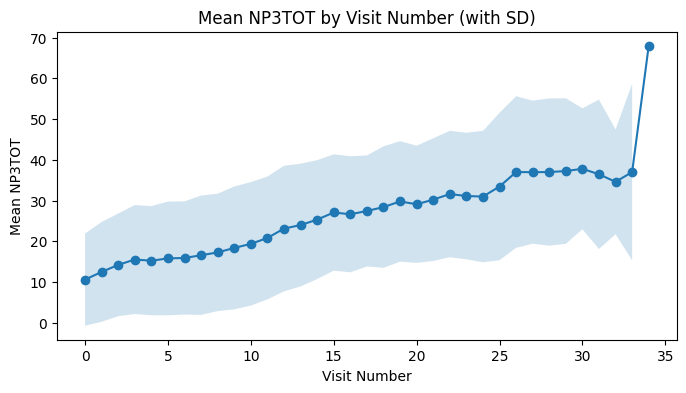

In [12]:
mean_by_visit = data.groupby('VISIT_NUM')['NP3TOT'].mean()
std_by_visit = data.groupby('VISIT_NUM')['NP3TOT'].std()
plt.figure(figsize=(8, 4))
plt.plot(mean_by_visit.index, mean_by_visit.values, marker='o')
plt.fill_between(mean_by_visit.index, 
                 mean_by_visit - std_by_visit, 
                 mean_by_visit + std_by_visit, 
                 alpha=0.2)
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number (with SD)')
plt.show()

In [13]:
# 2. Stratify by PDSTATE (ON/OFF)
print("\nNP3TOT by PDSTATE:")
print(data.groupby('PDSTATE')['NP3TOT'].describe())


NP3TOT by PDSTATE:
          count       mean        std  min   25%   50%   75%    max
PDSTATE                                                            
OFF      4405.0  29.808173  14.219594  1.0  19.0  28.0  38.0  100.0
ON       6863.0  22.489145  12.379274  0.0  13.0  21.0  30.0   89.0


In [14]:
# 3. Stratify by EVENT_ID (visit)
print("\nNP3TOT by EVENT_ID (first 5 visits):")
print(data.groupby('EVENT_ID')['NP3TOT'].describe().head())


NP3TOT by EVENT_ID (first 5 visits):
           count       mean        std  min  25%   50%   75%   max
EVENT_ID                                                          
BL        4229.0  11.222038  11.684420  0.0  2.0   7.0  18.0  71.0
PW          13.0  22.923077  21.765652  0.0  8.0  14.0  38.0  70.0
R01        103.0   6.611650   8.173646  0.0  1.0   4.0   9.0  43.0
R04         33.0   7.090909   8.527029  0.0  2.0   4.0  10.0  36.0
R06         73.0  18.315068  14.102676  0.0  6.0  17.0  28.0  57.0


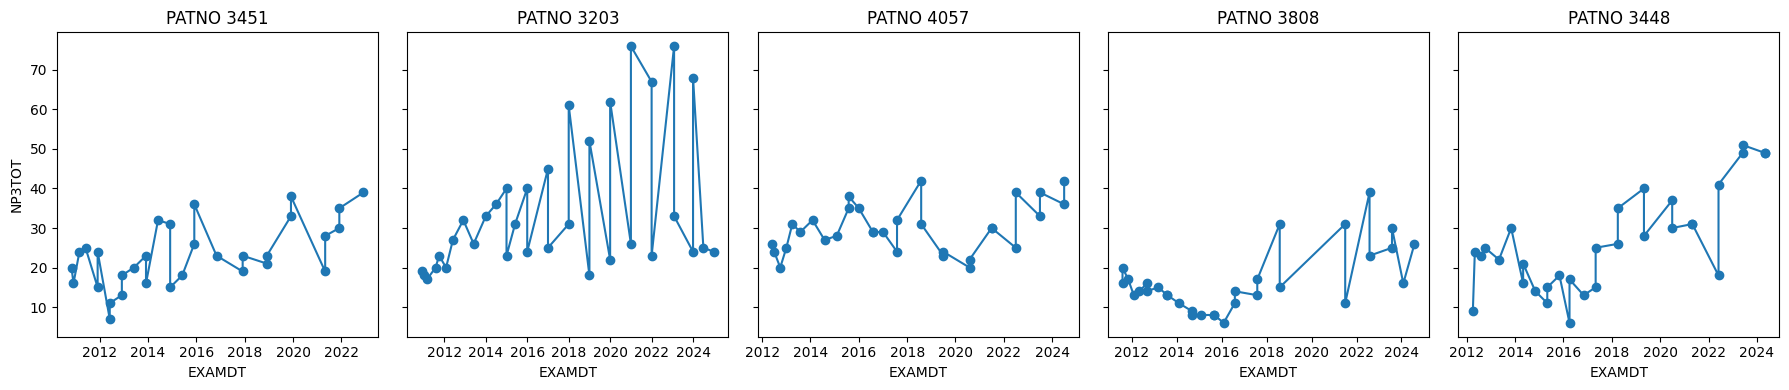

In [15]:
sample_patnos = [3451, 3203, 4057, 3808, 3448]

fig, axes = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
for ax, patno in zip(axes, sample_patnos):
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    ax.plot(patient['EXAMDT'], patient['NP3TOT'], marker='o')
    ax.set_title(f'PATNO {patno}')
    ax.set_xlabel('EXAMDT')
axes[0].set_ylabel('NP3TOT')
plt.tight_layout()
plt.show()

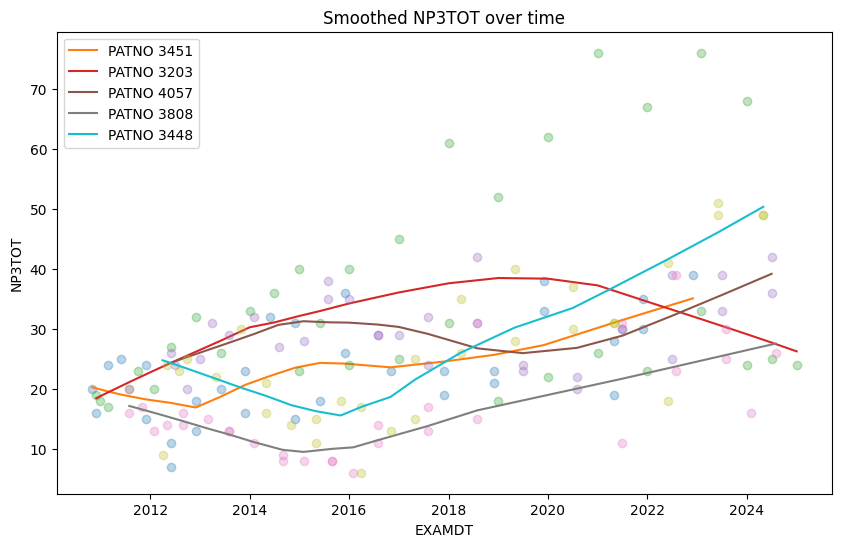

In [16]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
for patno in sample_patnos:
    patient = data[(data['PATNO'] == patno) & data['EXAMDT'].notna() & data['NP3TOT'].notna()]
    patient = patient.sort_values('EXAMDT')
    if len(patient) > 2:
        # Convert EXAMDT to matplotlib date numbers for LOWESS
        x = mdates.date2num(patient['EXAMDT'])
        y = patient['NP3TOT'].values
        smoothed = lowess(y, x, frac=0.5)
        # Plot original points
        plt.plot(patient['EXAMDT'], y, 'o', alpha=0.3)
        # Plot smoothed line, converting x back to datetime
        plt.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], label=f'PATNO {patno}')
plt.xlabel('EXAMDT')
plt.ylabel('NP3TOT')
plt.title('Smoothed NP3TOT over time')
plt.legend()
plt.show()

# Modeling Disease Progression

Fit linear mixed models or other longitudinal models to estimate progression rates and account for within-patient correlation.

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

In [18]:
# 1. Calculate change in NP3TOT from baseline for each patient
data['NP3TOT_BL'] = data.groupby('PATNO')['NP3TOT'].transform('first')
data['NP3TOT_CHANGE'] = data['NP3TOT'] - data['NP3TOT_BL']
print("Change from baseline (first 10 rows):")
print(data[['PATNO', 'EXAMDT', 'NP3TOT', 'NP3TOT_BL', 'NP3TOT_CHANGE']].head(10))

Change from baseline (first 10 rows):
    PATNO     EXAMDT  NP3TOT  NP3TOT_BL  NP3TOT_CHANGE
0    3000 2011-02-01     4.0        4.0            0.0
1    3000 2012-03-01     1.0        4.0           -3.0
2    3000 2013-02-01     4.0        4.0            0.0
3    3000 2014-03-01     2.0        4.0           -2.0
4    3000 2015-03-01    19.0        4.0           15.0
5    3000 2016-04-01     3.0        4.0           -1.0
6    3000 2018-02-01    10.0        4.0            6.0
7    3000 2019-03-01     5.0        4.0            1.0
8    3000 2021-05-01     3.0        4.0           -1.0
10   3001 2011-02-01    18.0       18.0            0.0


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: NP3TOT     
No. Observations: 26109   Method:             REML       
No. Groups:       4298    Scale:              55.6501    
Min. group size:  1       Log-Likelihood:     -94396.5154
Max. group size:  35      Converged:          Yes        
Mean group size:  6.1                                    
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept      10.877    0.188 57.836 0.000 10.508 11.245
DAYS_SINCE_BL   0.003    0.000 51.982 0.000  0.003  0.003
Group Var     126.769    0.444                           



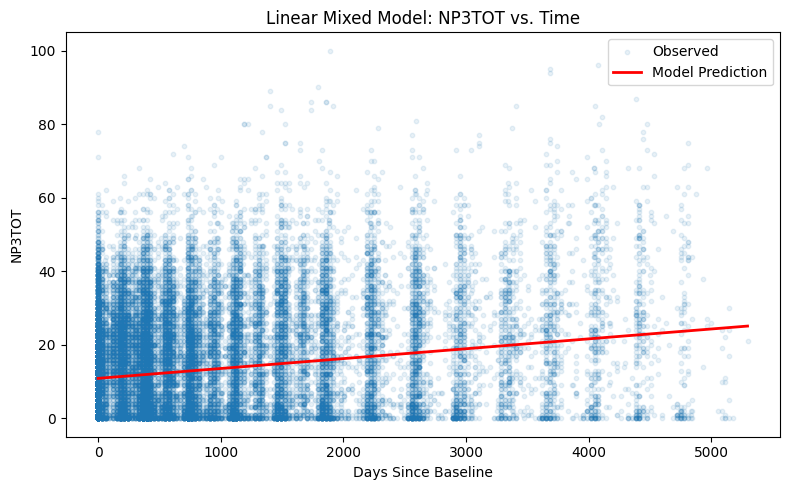

In [19]:
import numpy as np

# 2. Model trajectories: Linear mixed model (NP3TOT ~ time)
# Only use rows with valid EXAMDT and NP3TOT
model_data = data.dropna(subset=['EXAMDT', 'NP3TOT'])
model_data['DAYS_SINCE_BL'] = (model_data['EXAMDT'] - model_data.groupby('PATNO')['EXAMDT'].transform('min')).dt.days
md = smf.mixedlm("NP3TOT ~ DAYS_SINCE_BL", model_data, groups=model_data["PATNO"])
mdf = md.fit()
print(mdf.summary())

# Plot observed NP3TOT vs. DAYS_SINCE_BL with model prediction line
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(model_data['DAYS_SINCE_BL'], model_data['NP3TOT'], alpha=0.1, label='Observed', s=10)

# Predicted line (fixed effects only)
x_pred = np.linspace(model_data['DAYS_SINCE_BL'].min(), model_data['DAYS_SINCE_BL'].max(), 200)
y_pred = mdf.params['Intercept'] + mdf.params['DAYS_SINCE_BL'] * x_pred
plt.plot(x_pred, y_pred, color='red', linewidth=2, label='Model Prediction')

plt.xlabel('Days Since Baseline')
plt.ylabel('NP3TOT')
plt.title('Linear Mixed Model: NP3TOT vs. Time')
plt.legend()
plt.tight_layout()
plt.show()


Fitting LMM with quadratic time effect (fixed effect only)...
          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: NP3TOT     
No. Observations:  26109   Method:             REML       
No. Groups:        4298    Scale:              55.6519    
Min. group size:   1       Log-Likelihood:     -94409.9487
Max. group size:   35      Converged:          Yes        
Mean group size:   6.1                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       10.796    0.191 56.528 0.000 10.422 11.170
DAYS_SINCE_BL    0.003    0.000 21.672 0.000  0.003  0.003
DAYS_SINCE_BL2  -0.000    0.000 -2.366 0.018 -0.000 -0.000
Group Var      126.585    0.443                           



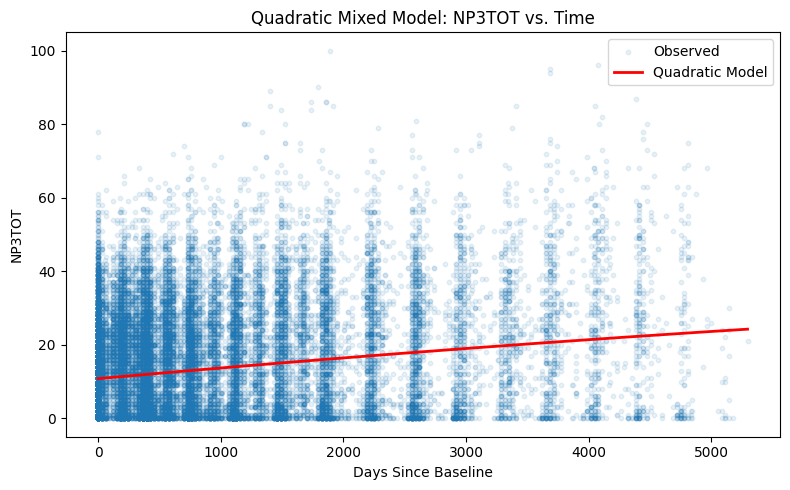

In [20]:
# 2. Linear Mixed Model with Non-linear (Quadratic) Time Effect
print("\nFitting LMM with quadratic time effect (fixed effect only)...")
model_data['DAYS_SINCE_BL2'] = model_data['DAYS_SINCE_BL'] ** 2
md_quad = smf.mixedlm("NP3TOT ~ DAYS_SINCE_BL + DAYS_SINCE_BL2", model_data, groups=model_data["PATNO"])
mdf_quad = md_quad.fit()
print(mdf_quad.summary())

# Plot observed NP3TOT vs. DAYS_SINCE_BL with quadratic model prediction line
plt.figure(figsize=(8, 5))
plt.scatter(model_data['DAYS_SINCE_BL'], model_data['NP3TOT'], alpha=0.1, label='Observed', s=10)

# Predicted line (fixed effects only, quadratic)
y_pred_quad = mdf_quad.params['Intercept'] + mdf_quad.params['DAYS_SINCE_BL'] * x_pred + mdf_quad.params['DAYS_SINCE_BL2'] * x_pred**2
plt.plot(x_pred, y_pred_quad, color='red', linewidth=2, label='Quadratic Model')

plt.xlabel('Days Since Baseline')
plt.ylabel('NP3TOT')
plt.title('Quadratic Mixed Model: NP3TOT vs. Time')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# # 3. (Optional) Linear Mixed Model with both random slope and quadratic time effect
# print("\nFitting LMM with random slope and quadratic time effect...")
# md_rs_quad = smf.mixedlm("NP3TOT ~ DAYS_SINCE_BL + DAYS_SINCE_BL2", model_data, groups=model_data["PATNO"], re_formula="~DAYS_SINCE_BL")
# mdf_rs_quad = md_rs_quad.fit()
# print(mdf_rs_quad.summary())

# # Plot observed NP3TOT vs. DAYS_SINCE_BL with model prediction (random slope + quadratic)
# plt.figure(figsize=(8, 5))
# plt.scatter(model_data['DAYS_SINCE_BL'], model_data['NP3TOT'], alpha=0.1, label='Observed', s=10)

# # Predicted line (fixed effects only, quadratic)
# y_pred_rs_quad = mdf_rs_quad.params['Intercept'] + mdf_rs_quad.params['DAYS_SINCE_BL'] * x_pred + mdf_rs_quad.params['DAYS_SINCE_BL2'] * x_pred**2
# plt.plot(x_pred, y_pred_rs_quad, color='red', linewidth=2, label='Random Slope + Quadratic Model')

# plt.xlabel('Days Since Baseline')
# plt.ylabel('NP3TOT')
# plt.title('Mixed Model: NP3TOT vs. Time (Random Slope + Quadratic)')
# plt.legend()
# plt.tight_layout()
# plt.show()


LMM: NP3TOT ~ DAYS_SINCE_BL + C(PDSTATE)


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/679699484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lmm_data['PDSTATE'] = lmm_data['PDSTATE'].astype('category')


           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  NP3TOT     
No. Observations:  11268    Method:              REML       
No. Groups:        1232     Scale:               67.3198    
Min. group size:   1        Log-Likelihood:      -41167.6214
Max. group size:   30       Converged:           Yes        
Mean group size:   9.1                                      
------------------------------------------------------------
                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept        25.696    0.330  77.980 0.000 25.050 26.342
C(PDSTATE)[T.ON] -7.655    0.166 -46.235 0.000 -7.979 -7.330
DAYS_SINCE_BL     0.003    0.000  38.279 0.000  0.003  0.004
Group Var        94.527    0.554                            


LMM: NP3TOT ~ DAYS_SINCE_BL * C(PDSTATE)
                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:  

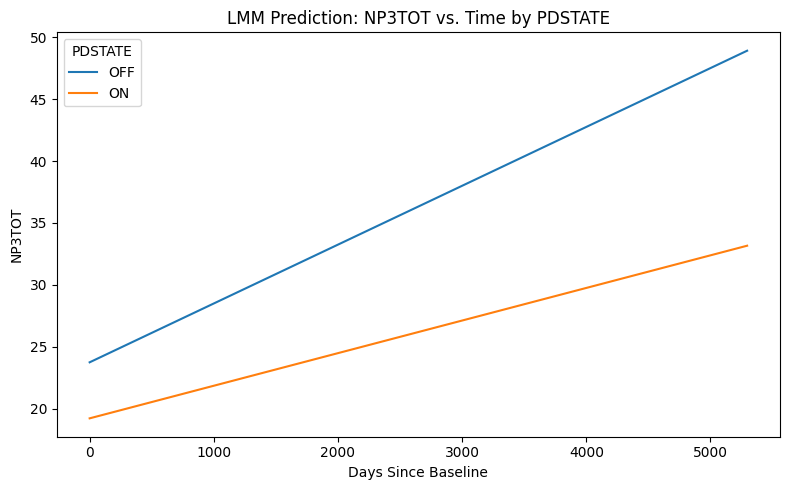

In [22]:
# --- Linear Mixed Model: Incorporate PDSTATE as fixed effect and interaction ---

# 1. Drop rows with missing PDSTATE (or impute if you prefer)
lmm_data = model_data.dropna(subset=['PDSTATE'])
lmm_data['PDSTATE'] = lmm_data['PDSTATE'].astype('category')

# 2. LMM: Add PDSTATE as a fixed effect (categorical)
print("\nLMM: NP3TOT ~ DAYS_SINCE_BL + C(PDSTATE)")
md_pdstate = smf.mixedlm("NP3TOT ~ DAYS_SINCE_BL + C(PDSTATE)", lmm_data, groups=lmm_data["PATNO"])
mdf_pdstate = md_pdstate.fit()
print(mdf_pdstate.summary())

# 3. LMM: Add interaction term (does progression differ by PDSTATE?)
print("\nLMM: NP3TOT ~ DAYS_SINCE_BL * C(PDSTATE)")
md_inter = smf.mixedlm("NP3TOT ~ DAYS_SINCE_BL * C(PDSTATE)", lmm_data, groups=lmm_data["PATNO"])
mdf_inter = md_inter.fit()
print(mdf_inter.summary())

# 4. Plot model predictions for each PDSTATE
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 5))
for state in lmm_data['PDSTATE'].cat.categories:
    state_mask = lmm_data['PDSTATE'] == state
    x_pred = np.linspace(lmm_data['DAYS_SINCE_BL'].min(), lmm_data['DAYS_SINCE_BL'].max(), 200)
    # Build a DataFrame for prediction
    pred_df = pd.DataFrame({
        'DAYS_SINCE_BL': x_pred,
        'PDSTATE': state
    })
    # Predict using the interaction model
    y_pred = mdf_inter.predict(pred_df)
    plt.plot(x_pred, y_pred, label=f"{state}")

plt.xlabel('Days Since Baseline')
plt.ylabel('NP3TOT')
plt.title('LMM Prediction: NP3TOT vs. Time by PDSTATE')
plt.legend(title='PDSTATE')
plt.tight_layout()
plt.show()

In [23]:
# 3. Treatment effect: ON vs. OFF within-patient (paired analysis)
paired_idx = data.groupby(['PATNO', 'EVENT_ID'])['PDSTATE'].transform('nunique') > 1
paired_data = data[paired_idx]
on_scores = paired_data[paired_data['PDSTATE'] == 'ON'].set_index(['PATNO', 'EVENT_ID'])
off_scores = paired_data[paired_data['PDSTATE'] == 'OFF'].set_index(['PATNO', 'EVENT_ID'])
common_idx = on_scores.index.intersection(off_scores.index)
np3tot_diff = on_scores.loc[common_idx, 'NP3TOT'] - off_scores.loc[common_idx, 'NP3TOT']
print("\nON - OFF NP3TOT difference (summary):")
print(np3tot_diff.describe())


ON - OFF NP3TOT difference (summary):
count    3579.000000
mean       -9.559654
std         8.299959
min       -90.000000
25%       -13.000000
50%        -8.000000
75%        -4.000000
max        18.000000
Name: NP3TOT, dtype: float64


In [24]:
from scipy.stats import ttest_rel, wilcoxon

# Paired t-test
t, p_t = ttest_rel(on_scores['NP3TOT'], off_scores['NP3TOT'])
print(f"Paired t-test ON vs. OFF: t={t:.2f}, p={p_t:.3g}")

# Wilcoxon signed-rank test (non-parametric)
w, p_w = wilcoxon(on_scores['NP3TOT'], off_scores['NP3TOT'])
print(f"Wilcoxon signed-rank test ON vs. OFF: W={w:.2f}, p={p_w:.3g}")

if p_t < 0.05:
    print("Significant difference between ON and OFF (paired t-test).")
if p_w < 0.05:
    print("Significant difference between ON and OFF (Wilcoxon).")

Paired t-test ON vs. OFF: t=-68.91, p=0
Wilcoxon signed-rank test ON vs. OFF: W=66749.50, p=0
Significant difference between ON and OFF (paired t-test).
Significant difference between ON and OFF (Wilcoxon).



Mean NP3TOT by visit (treated):
VISIT_NUM
0    20.779141
1    21.257471
2    21.568938
3    22.090776
4    22.404227
Name: NP3TOT, dtype: float64

Mean NP3TOT by visit (untreated):
VISIT_NUM
0     9.658317
1    11.424419
2    12.590617
3    13.720971
4    11.520138
Name: NP3TOT, dtype: float64


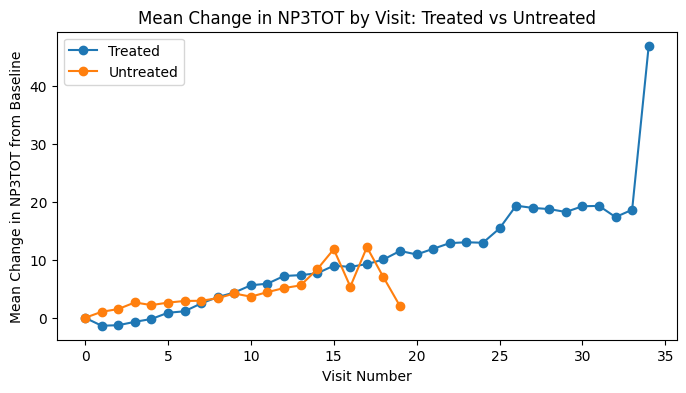

In [25]:
# 4. Compare treated vs. untreated over time (PDTRTMNT)
if 'PDTRTMNT' in data.columns:
    treated = data[data['PDTRTMNT'] == 1.0]
    untreated = data[data['PDTRTMNT'] == 0.0]
    print("\nMean NP3TOT by visit (treated):")
    print(treated.groupby('VISIT_NUM')['NP3TOT'].mean().head())
    print("\nMean NP3TOT by visit (untreated):")
    print(untreated.groupby('VISIT_NUM')['NP3TOT'].mean().head())

    # Calculate change from baseline for each patient
    data['NP3TOT_BL'] = data.groupby('PATNO')['NP3TOT'].transform('first')
    data['NP3TOT_CHANGE'] = data['NP3TOT'] - data['NP3TOT_BL']

    # Plot mean change from baseline by group
    plt.figure(figsize=(8, 4))
    treated_change = data[data['PDTRTMNT'] == 1.0].groupby('VISIT_NUM')['NP3TOT_CHANGE'].mean()
    untreated_change = data[data['PDTRTMNT'] == 0.0].groupby('VISIT_NUM')['NP3TOT_CHANGE'].mean()
    plt.plot(treated_change, marker='o', label='Treated')
    plt.plot(untreated_change, marker='o', label='Untreated')
    plt.xlabel('Visit Number')
    plt.ylabel('Mean Change in NP3TOT from Baseline')
    plt.title('Mean Change in NP3TOT by Visit: Treated vs Untreated')
    plt.legend()
    plt.show()

In [26]:
# 5. Progression rates: Annualized change in NP3TOT, NHY
def annualized_change(df, score):
    df = df.sort_values('EXAMDT')
    if len(df) < 2:
        return np.nan
    days = (df['EXAMDT'].iloc[-1] - df['EXAMDT'].iloc[0]).days
    if days == 0:
        return np.nan
    return (df[score].iloc[-1] - df[score].iloc[0]) / (days / 365.25)

annual_np3tot = data.dropna(subset=['EXAMDT', 'NP3TOT']).groupby('PATNO').apply(annualized_change, 'NP3TOT')
print("\nAnnualized NP3TOT change (summary):")
print(annual_np3tot.describe())


Annualized NP3TOT change (summary):
count    3218.000000
mean        1.041656
std         6.859231
min      -119.754098
25%        -0.444343
50%         0.415157
75%         2.660476
max       146.100000
dtype: float64


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/2082637321.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  annual_np3tot = data.dropna(subset=['EXAMDT', 'NP3TOT']).groupby('PATNO').apply(annualized_change, 'NP3TOT')


In [27]:
# 6. Correlation analysis: NP3TOT with NHY, and between NP3 items
corr_np3tot_nhy = data[['NP3TOT', 'NHY']].dropna()
corr, pval = pearsonr(corr_np3tot_nhy['NP3TOT'], corr_np3tot_nhy['NHY'])
print(f"\nCorrelation between NP3TOT and NHY: r={corr:.2f}, p={pval:.3g}")

# Correlation matrix for key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
corr_matrix = data[key_items].corr()
print("\nCorrelation matrix for key NP3 items:")
print(corr_matrix)


Correlation between NP3TOT and NHY: r=0.79, p=0

Correlation matrix for key NP3 items:
            NP3TOT       NHY   NP3SPCH  NP3FACXP   NP3RIGN   NP3GAIT  NP3BRADY
NP3TOT    1.000000  0.792926  0.634496  0.748446  0.680415  0.667443  0.815013
NHY       0.792926  1.000000  0.531012  0.653695  0.535433  0.584383  0.714279
NP3SPCH   0.634496  0.531012  1.000000  0.635132  0.461373  0.464323  0.575407
NP3FACXP  0.748446  0.653695  0.635132  1.000000  0.546957  0.518476  0.713517
NP3RIGN   0.680415  0.535433  0.461373  0.546957  1.000000  0.426757  0.584351
NP3GAIT   0.667443  0.584383  0.464323  0.518476  0.426757  1.000000  0.597296
NP3BRADY  0.815013  0.714279  0.575407  0.713517  0.584351  0.597296  1.000000


In [28]:
from scipy.stats import spearmanr

# Spearman correlation for NP3TOT vs NHY
spearman_corr, spearman_p = spearmanr(data['NP3TOT'], data['NHY'], nan_policy='omit')
print(f"Spearman correlation between NP3TOT and NHY: ρ={spearman_corr:.2f}, p={spearman_p:.3g}")

# Spearman correlation matrix for key NP3 items
key_items = ['NP3TOT', 'NHY', 'NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3GAIT', 'NP3BRADY']
spearman_matrix = data[key_items].corr(method='spearman')
print("\nSpearman correlation matrix for key NP3 items:")
print(spearman_matrix)

Spearman correlation between NP3TOT and NHY: ρ=0.84, p=0

Spearman correlation matrix for key NP3 items:
            NP3TOT       NHY   NP3SPCH  NP3FACXP   NP3RIGN   NP3GAIT  NP3BRADY
NP3TOT    1.000000  0.838920  0.626258  0.769517  0.661238  0.664350  0.825120
NHY       0.838920  1.000000  0.547103  0.682021  0.562746  0.571808  0.743074
NP3SPCH   0.626258  0.547103  1.000000  0.643170  0.458055  0.450985  0.588033
NP3FACXP  0.769517  0.682021  0.643170  1.000000  0.541664  0.536789  0.724088
NP3RIGN   0.661238  0.562746  0.458055  0.541664  1.000000  0.421557  0.575116
NP3GAIT   0.664350  0.571808  0.450985  0.536789  0.421557  1.000000  0.596739
NP3BRADY  0.825120  0.743074  0.588033  0.724088  0.575116  0.596739  1.000000


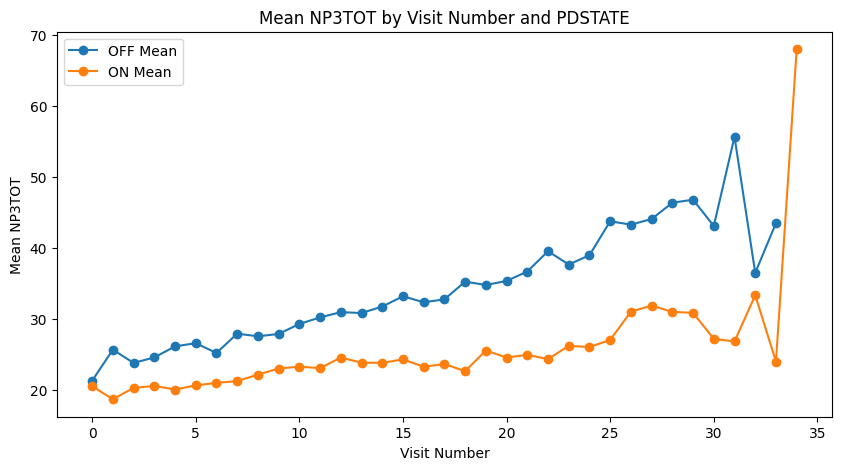

In [29]:
plt.figure(figsize=(10, 5))
data['PDSTATE'] = data['PDSTATE'].astype('category')
for state in data['PDSTATE'].cat.categories:
    state_data = data[data['PDSTATE'] == state]
    mean_trend = state_data.groupby('VISIT_NUM')['NP3TOT'].mean()
    plt.plot(mean_trend.index, mean_trend.values, marker='o', label=f'{state} Mean')
plt.xlabel('Visit Number')
plt.ylabel('Mean NP3TOT')
plt.title('Mean NP3TOT by Visit Number and PDSTATE')
plt.legend()
plt.show()

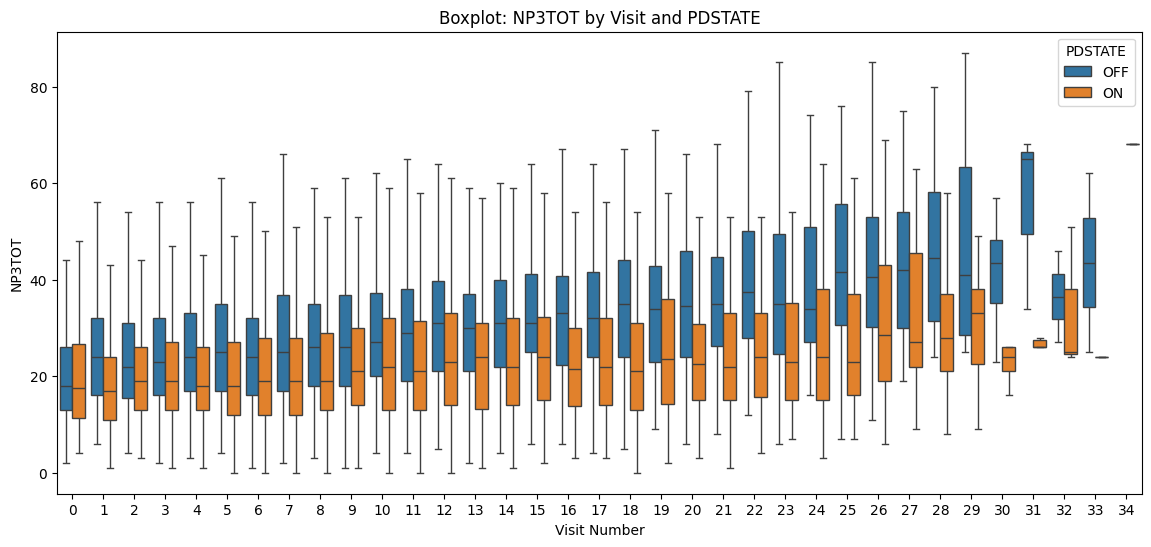

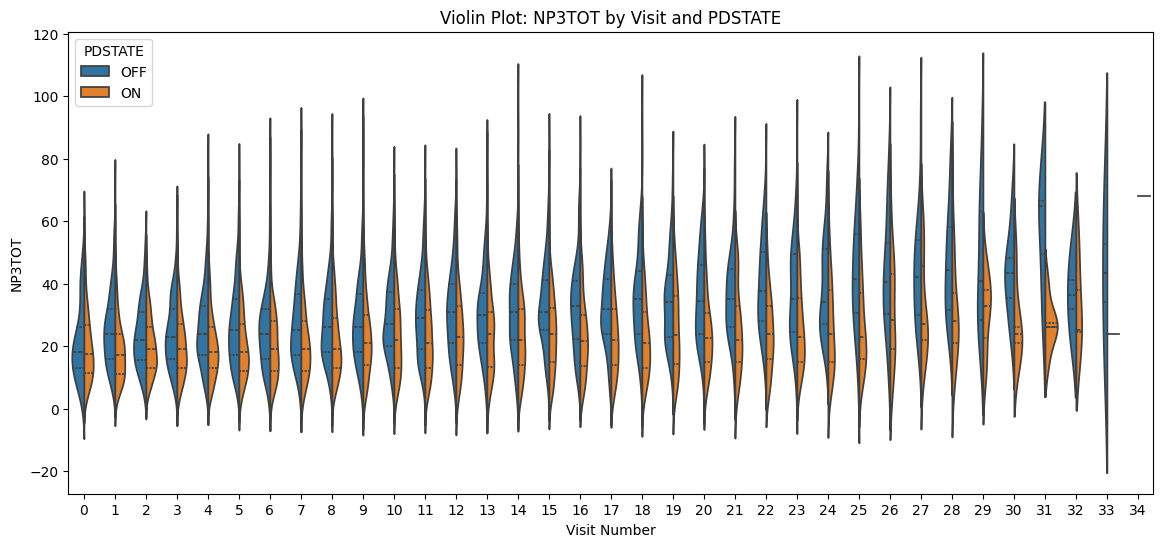

In [30]:
# 3. Boxplots/violin plots: NP3TOT by visit and PDSTATE
plt.figure(figsize=(14, 6))
sns.boxplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, showfliers=False)
plt.title('Boxplot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(x='VISIT_NUM', y='NP3TOT', hue='PDSTATE', data=data, split=True, inner='quartile')
plt.title('Violin Plot: NP3TOT by Visit and PDSTATE')
plt.xlabel('Visit Number')
plt.ylabel('NP3TOT')
plt.legend(title='PDSTATE')
plt.show()

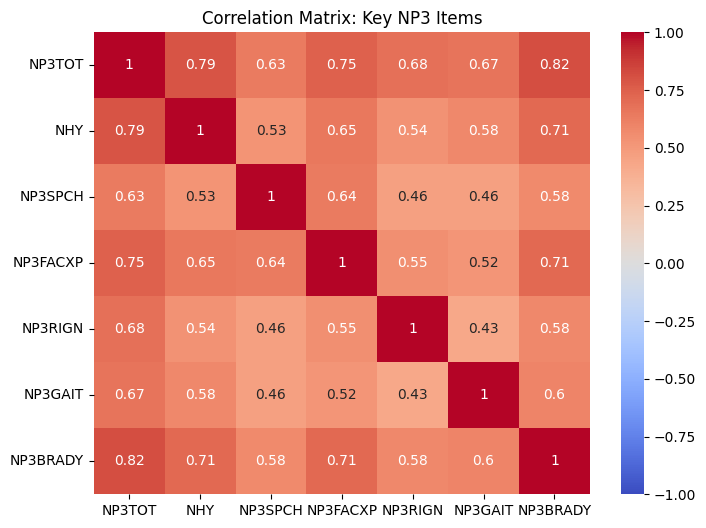

In [31]:
# 5. Heatmap: Correlation matrix for key NP3 items
corr_matrix = data[key_items].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Key NP3 Items')
plt.show()

# Machine Learning

In [32]:
DATA_DIR_2 = '/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv'
machine_learning_data = pd.read_csv(DATA_DIR_2)

In [33]:
# Convert date columns to datetime where possible
for col in ['INFODT', 'EXAMDT', 'ORIG_ENTRY', 'LAST_UPDATE']:
    if col in machine_learning_data.columns:
        machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')

# Convert specific date columns
machine_learning_data['EXAMDT'] = pd.to_datetime(machine_learning_data['EXAMDT'], errors='coerce')
machine_learning_data['INFODT'] = pd.to_datetime(machine_learning_data['INFODT'], errors='coerce')

# Fallback: fill missing EXAMDT with INFODT
machine_learning_data['EXAMDT'] = machine_learning_data['EXAMDT'].fillna(machine_learning_data['INFODT'])

# Replace 101 values with NaN in NP3 columns
np3_cols = [col for col in machine_learning_data.columns if col.startswith('NP3') and col != 'NP3TOT']
machine_learning_data[np3_cols] = machine_learning_data[np3_cols].replace(101, np.nan)

#Check outliers or wrong values
np3_cols = [col for col in machine_learning_data.columns if col.startswith('NP3') and col != 'NP3TOT']

# Find out-of-range values
out_of_range = (machine_learning_data[np3_cols] < 0) | (machine_learning_data[np3_cols] > 4)
if out_of_range.any().any():
    print("Warning: Out-of-range NP3 scores detected!")
    display(machine_learning_data.loc[out_of_range.any(axis=1), ['PATNO', 'EXAMDT'] + np3_cols])
else:
    print("All NP3 scores within expected range (0–4). Ignored NP3TOT.")

# Drop rows where NP3TOT is NaN
machine_learning_data = machine_learning_data.dropna(subset=['NP3TOT'])
print(f"Remaining rows after dropping NaN NP3TOT: {len(machine_learning_data)}")


All NP3 scores within expected range (0–4). Ignored NP3TOT.
Remaining rows after dropping NaN NP3TOT: 26109


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/2176198891.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/2176198891.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_learning_data[col] = pd.to_datetime(machine_learning_data[col], errors='coerce')
/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_54221/2176198891.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  machine_learning_d

In [34]:
motor_features = [
    'PATNO', 'EVENT_ID', 'INFODT',  # Identifying information

    # MDS-UPDRS Part III scores
    'NP3SPCH', 'NP3FACXP',
    'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL',  # Rigidity
    'NP3FTAPR', 'NP3FTAPL',  # Finger tapping
    'NP3HMOVR', 'NP3HMOVL',  # Hand movements
    'NP3PRSPR', 'NP3PRSPL',  # Pronation-supination
    'NP3TTAPR', 'NP3TTAPL',  # Toe tapping
    'NP3LGAGR', 'NP3LGAGL',  # Leg agility
    'NP3RISNG',  # Arising from chair
    'NP3GAIT', 'NP3FRZGT',  # Gait and freezing
    'NP3PSTBL',  # Postural stability
    'NP3POSTR',  # Posture
    'NP3BRADY',  # Body bradykinesia
    'NP3PTRMR', 'NP3PTRML',  # Postural tremor
    'NP3KTRMR', 'NP3KTRML',  # Kinetic tremor
    'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',  # Rest tremor
    'NP3TOT'  # Total score (needed for target creation)
]


In [35]:
# Keep only relevant columns available in the dataset
motor_df = machine_learning_data[[col for col in motor_features if col in machine_learning_data.columns]].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Initial motor assessment DataFrame shape: {motor_df.shape}")

Initial motor assessment DataFrame shape: (26109, 37)


In [36]:
# Define the expected components of NP3TOT based on MDS-UPDRS guidelines
# These are the column names as they appear in your CSV/DataFrame
expected_np3_components = [
    'NP3SPCH',  # 3.1
    'NP3FACXP', # 3.2
    'NP3RIGN',  # 3.3a
    'NP3RIGRU', # 3.3b
    'NP3RIGLU', # 3.3c
    'NP3RIGRL', # 3.3d
    'NP3RIGLL', # 3.3e
    'NP3FTAPR', # 3.4a
    'NP3FTAPL', # 3.4b
    'NP3HMOVR', # 3.5a
    'NP3HMOVL', # 3.5b
    'NP3PRSPR', # 3.6a
    'NP3PRSPL', # 3.6b
    'NP3TTAPR', # 3.7a
    'NP3TTAPL', # 3.7b
    'NP3LGAGR', # 3.8a
    'NP3LGAGL', # 3.8b
    'NP3RISNG', # 3.9
    'NP3GAIT',  # 3.10
    'NP3FRZGT', # 3.11
    'NP3PSTBL', # 3.12
    'NP3POSTR', # 3.13
    'NP3BRADY', # 3.14
    'NP3PTRMR', # 3.15a (Postural Tremor Right Hand)
    'NP3PTRML', # 3.15b (Postural Tremor Left Hand)
    'NP3KTRMR', # 3.16a (Kinetic Tremor Right Hand)
    'NP3KTRML', # 3.16b (Kinetic Tremor Left Hand)
    'NP3RTARU', # 3.17a (Rest Tremor Right Upper Extremity)
    'NP3RTALU', # 3.17b (Rest Tremor Left Upper Extremity)
    'NP3RTARL', # 3.17c (Rest Tremor Right Lower Extremity)
    'NP3RTALL', # 3.17d (Rest Tremor Left Lower Extremity)
    'NP3RTALJ', # 3.17e (Rest Tremor Jaw)
    'NP3RTCON'  # 3.18 (Rest Tremor Constancy)
]

# motor_features is defined in a previous cell.
# Let's find which features in motor_features are part of the expected NP3 components
actual_np3_sum_components_in_motor_features = [col for col in motor_features if col in expected_np3_components]

print(f"Number of expected NP3 components: {len(expected_np3_components)}")
print(f"Expected NP3 components: {expected_np3_components}")
print("-" * 50)
print(f"Number of NP3 sum components found in your 'motor_features' list: {len(actual_np3_sum_components_in_motor_features)}")
print(f"Actual NP3 sum components from 'motor_features': {actual_np3_sum_components_in_motor_features}")
print("-" * 50)

# Verify the sum for a few rows in the original motor_df (before any dropping of NaNs for specific columns if that happens later)
# Make sure motor_df is loaded and NP3TOT is present
if 'motor_df' in locals() and 'NP3TOT' in motor_df.columns:
    # Calculate the sum of these components for each row
    motor_df['Calculated_NP3TOT'] = motor_df[actual_np3_sum_components_in_motor_features].sum(axis=1)

    # Compare with the original NP3TOT
    # We'll check the first 5 rows and a few random rows where NP3TOT is not 0 (if any)
    comparison_df = motor_df[['NP3TOT', 'Calculated_NP3TOT']].copy()
    comparison_df['Difference'] = comparison_df['NP3TOT'] - comparison_df['Calculated_NP3TOT']

    print("Comparison of NP3TOT with sum of its identified components (first 5 rows):")
    print(comparison_df.head())
    print("-" * 50)

    # Check if all differences are zero (or very close to zero, allowing for potential float precision issues if data was manipulated)
    if comparison_df['Difference'].abs().sum() < 1e-5: # A small tolerance for floating point arithmetic
        print("Verification successful: NP3TOT matches the sum of the identified components for all rows.")
    else:
        print("Verification FAILED: NP3TOT does NOT match the sum of the identified components for all rows.")
        print(f"Number of rows with mismatch: {len(comparison_df[comparison_df['Difference'].abs() > 1e-5])}")
        print("Rows with discrepancies:")
        print(comparison_df[comparison_df['Difference'].abs() > 1e-5].head())

    # It's good practice to drop the temporary column if you don't need it later
    # motor_df.drop(columns=['Calculated_NP3TOT'], inplace=True)
else:
    print("motor_df not found or NP3TOT column is missing. Cannot perform sum verification.")


Number of expected NP3 components: 33
Expected NP3 components: ['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON']
--------------------------------------------------
Number of NP3 sum components found in your 'motor_features' list: 33
Actual NP3 sum components from 'motor_features': ['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3

In [37]:
print("Missing values in motor_df BEFORE any dropna (immediately after creation):")
print(f"Shape of motor_df: {motor_df.shape}")
print("\nNaNs per column in motor_features + NP3TOT:")
nan_counts = motor_df[motor_features + ['NP3TOT']].isnull().sum()
print(nan_counts[nan_counts > 0]) # Only print columns that have NaNs

print(f"\nTotal rows with any NaN in motor_features: {motor_df[motor_features].isnull().any(axis=1).sum()}")
print(f"Total rows with NaN in NP3TOT: {motor_df['NP3TOT'].isnull().sum()}")

# Display a few rows that have NaNs in any of the motor_feature columns for context
if motor_df[motor_features].isnull().any(axis=1).sum() > 0:
    print("\nExample rows with NaNs in motor_features:")
    print(motor_df[motor_df[motor_features].isnull().any(axis=1)].head())

Missing values in motor_df BEFORE any dropna (immediately after creation):
Shape of motor_df: (26109, 38)

NaNs per column in motor_features + NP3TOT:
Series([], dtype: int64)

Total rows with any NaN in motor_features: 0
Total rows with NaN in NP3TOT: 0


In [38]:
motor_df.sort_values(['PATNO', 'INFODT'], inplace=True)

motor_df['days_since_baseline'] = motor_df.groupby('PATNO')['INFODT'].transform(lambda x: (x - x.min()).dt.days)

# --- Create the Target Variable: NP3TOT of the *next* visit ---
motor_df['NP3TOT_next_visit'] = motor_df.groupby('PATNO')['NP3TOT'].shift(-1)

# --- Create Lag Features (Example: Previous NP3TOT) ---
# This demonstrates adding explicit time features. Can add more lags or differences.
motor_df['NP3TOT_lag1'] = motor_df.groupby('PATNO')['NP3TOT'].shift(1)
motor_df['NP3TOT_diff1'] = motor_df.groupby('PATNO')['NP3TOT'].diff(1)
# Add lag 2 features
motor_df['NP3TOT_lag2'] = motor_df.groupby('PATNO')['NP3TOT'].shift(2)
motor_df['NP3TOT_diff2'] = motor_df.groupby('PATNO')['NP3TOT'].diff(2)
# Add lag 3 features
motor_df['NP3TOT_lag3'] = motor_df.groupby('PATNO')['NP3TOT'].shift(3)
motor_df['NP3TOT_diff3'] = motor_df.groupby('PATNO')['NP3TOT'].diff(3)

motor_df['days_since_prev1'] = motor_df.groupby('PATNO')['INFODT'].diff(1).dt.days
motor_df['days_since_prev2'] = motor_df.groupby('PATNO')['INFODT'].diff(2).dt.days
motor_df['days_since_prev3'] = motor_df.groupby('PATNO')['INFODT'].diff(3).dt.days

In [39]:
# Drop rows where the target ('NP3TOT_next_visit') is NaN (these are the last visits per patient)
# Also drop rows where lag features are NaN (first visits)
progression_df = motor_df.dropna(subset=[
    'NP3TOT_next_visit', 
    'NP3TOT_lag1', 'NP3TOT_diff1', 
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]).copy()

print(f"\nShape after creating target and lag features & dropping NaNs: {progression_df.shape}")


Shape after creating target and lag features & dropping NaNs: (14182, 49)


In [40]:
# Original selection of NP3 items (current visit)
individual_np3_items = [col for col in progression_df.columns if 
                        col.startswith('NP3') and 
                        col not in ['NP3TOT', 'NP3TOT_next_visit'] and
                        not col.startswith('NP3TOT_lag') and 
                        not col.startswith('NP3TOT_diff')]

# Explicitly list all engineered features to ensure no overlap and correct selection
engineered_features = [
    'days_since_baseline',
    'NP3TOT_lag1', 'NP3TOT_diff1',
    'NP3TOT_lag2', 'NP3TOT_diff2',
    'NP3TOT_lag3', 'NP3TOT_diff3',
    'days_since_prev1', 'days_since_prev2', 'days_since_prev3'
]

feature_cols = individual_np3_items + engineered_features

# Ensure all listed engineered_features actually exist in progression_df.columns to avoid errors
feature_cols = [col for col in feature_cols if col in progression_df.columns]
# Remove duplicates just in case, and maintain order
from collections import OrderedDict
feature_cols = list(OrderedDict.fromkeys(feature_cols))


X = progression_df[feature_cols]
y = progression_df['NP3TOT_next_visit'] # y definition remains the same
groups = progression_df['PATNO'] # groups definition remains the same

print(f"\nCorrected Feature shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"Group shape: {groups.shape}")
print("\nCorrected Features used:")
print(X.columns.tolist())
print(f"\nNumber of features: {len(X.columns.tolist())}")


Corrected Feature shape (X): (14182, 43)
Target shape (y): (14182,)
Group shape: (14182,)

Corrected Features used:
['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'days_since_baseline', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2', 'NP3TOT_lag3', 'NP3TOT_diff3', 'days_since_prev1', 'days_since_prev2', 'days_since_prev3']

Number of features: 43


In [41]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}, groups={groups_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, groups={groups_test.shape}")
print(f"Number of unique patients in train: {groups_train.nunique()}")
print(f"Number of unique patients in test: {groups_test.nunique()}")

# Verify no patient overlap (should be empty)
train_patients = set(groups_train.unique())
test_patients = set(groups_test.unique())
print(f"Overlap patients: {train_patients.intersection(test_patients)}")


Train shapes: X=(11219, 43), y=(11219,), groups=(11219,)
Test shapes: X=(2963, 43), y=(2963,), groups=(2963,)
Number of unique patients in train: 1431
Number of unique patients in test: 358
Overlap patients: set()


In [42]:
scaler = StandardScaler()

# Fit scaler ONLY on training data
scaler.fit(X_train)

# Transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("\nScaled training data head:")
X_train_scaled.head()


Scaled training data head:


,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,...,days_since_baseline,NP3TOT_lag1,NP3TOT_diff1,NP3TOT_lag2,NP3TOT_diff2,NP3TOT_lag3,NP3TOT_diff3,days_since_prev1,days_since_prev2,days_since_prev3
3,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,0.298962,...,-0.295080,-1.033336,-0.262850,-1.233880,-0.005275,-1.018118,-0.341765,0.932906,1.206844,1.509111
4,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,0.087165,0.028955,1.455133,...,0.063485,-1.169533,1.719647,-1.024075,1.471611,-1.232118,1.656549,0.789245,1.311013,1.427569
5,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,-0.974617,0.028955,-0.857209,...,0.453485,-0.011855,-1.723637,-1.163945,-0.005275,-1.018118,-0.241850,0.953429,1.325894,1.596277
6,-0.794742,-1.134506,-0.796356,0.116804,-0.883783,-0.711267,-0.690476,0.087165,0.028955,-0.857209,...,1.112654,-1.101435,0.676228,0.024953,-1.060194,-1.160785,0.657392,2.359251,2.464313,2.377957
7,-0.794742,-1.134506,-0.796356,-0.998453,-0.883783,-0.711267,-0.690476,-0.974617,-0.976767,-0.857209,...,1.498724,-0.624743,-0.575876,-1.094010,0.100217,0.051883,-1.540754,0.932906,2.449432,2.456688


In [43]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100), # Good baseline
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'), # Specify objective for regression
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True) # Added early stopping
}

results_test = []


--- Evaluating on Test Set ---
Training Linear Regression...
Linear Regression: MAE=5.825, RMSE=7.956, R2=0.730


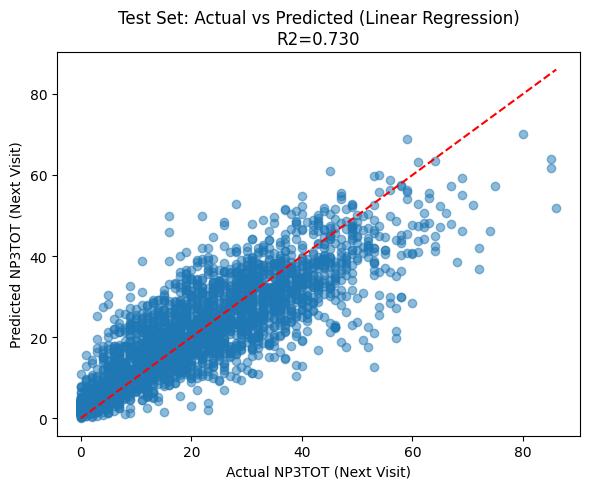

Training SVR...
SVR: MAE=5.921, RMSE=8.364, R2=0.702


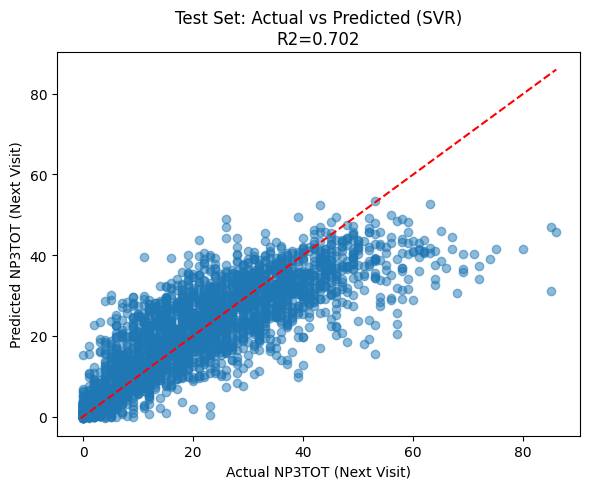

Training RandomForest Regressor...
RandomForest Regressor: MAE=5.861, RMSE=8.164, R2=0.716


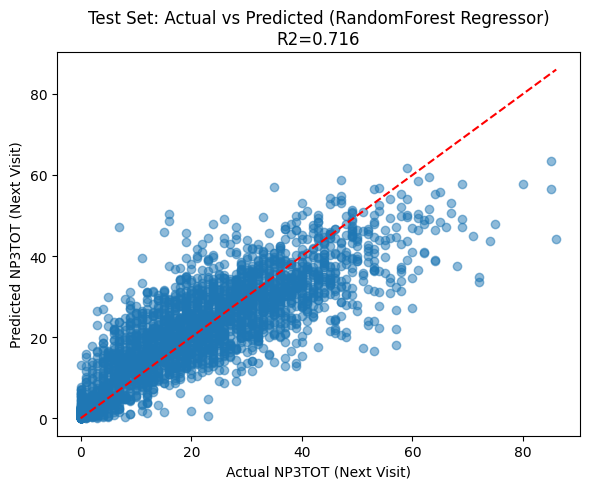

Training GradientBoosting Regressor...
GradientBoosting Regressor: MAE=5.818, RMSE=8.030, R2=0.725


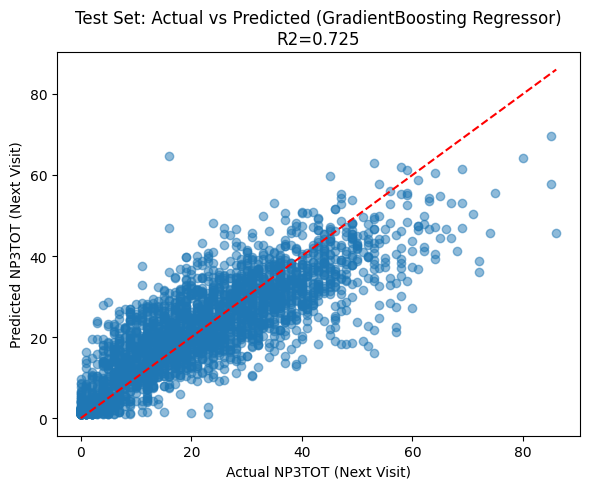

Training XGBoost...
XGBoost: MAE=5.988, RMSE=8.386, R2=0.700


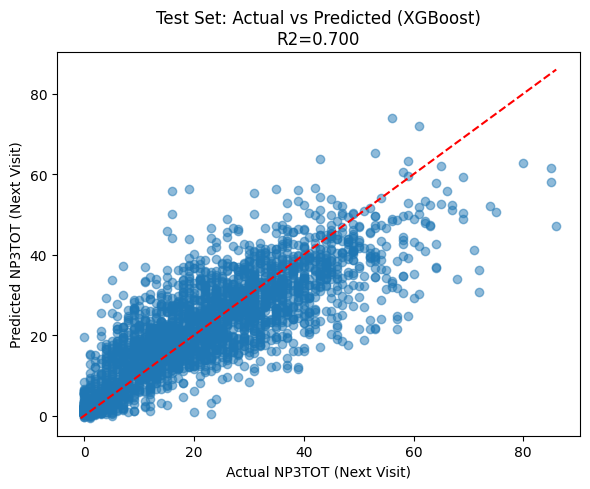

Training KNeighbors...
KNeighbors: MAE=6.514, RMSE=9.074, R2=0.649


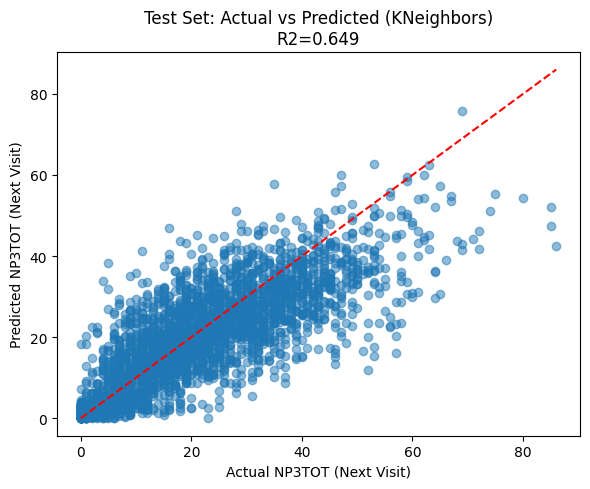

Training AdaBoostRegressor...
AdaBoostRegressor: MAE=9.673, RMSE=11.329, R2=0.453


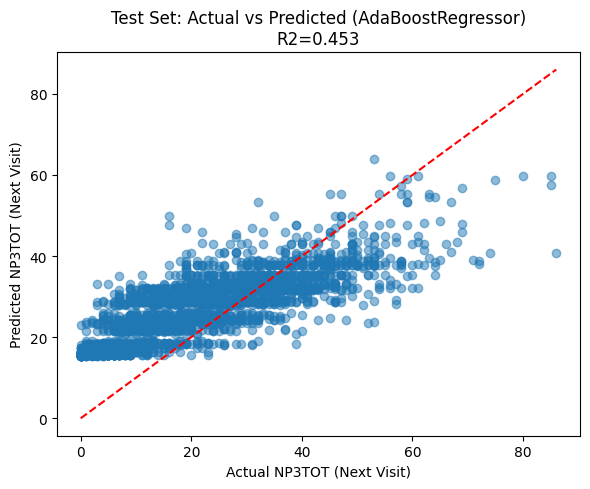

Training MLP Regressor...
MLP Regressor: MAE=5.882, RMSE=8.155, R2=0.716


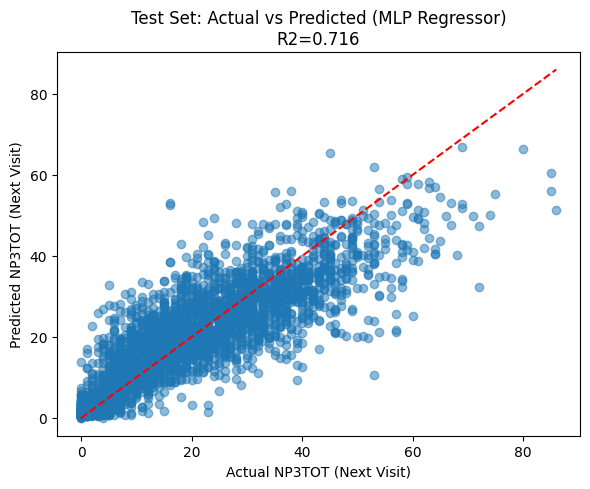


Test Set Performance Summary:
                        Model    MAE    RMSE  R-squared
0           Linear Regression  5.825   7.956      0.730
1                         SVR  5.921   8.364      0.702
2      RandomForest Regressor  5.861   8.164      0.716
3  GradientBoosting Regressor  5.818   8.030      0.725
4                     XGBoost  5.988   8.386      0.700
5                  KNeighbors  6.514   9.074      0.649
6           AdaBoostRegressor  9.673  11.329      0.453
7               MLP Regressor  5.882   8.155      0.716


In [44]:
# ## 7. Model Training and Evaluation (Single Split)

# Define models to train (Added RandomForest)
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'),
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True)
}

# Initialize results list
results_test = []

print("\n--- Evaluating on Test Set ---")
# Train and evaluate each model on the single train/test split
for name, model in models.items():
    print(f"Training {name}...")
    # --- MODIFICATION START ---
    # Convert DataFrames to NumPy arrays for fitting and prediction
    # Ensure y_train and y_test are also Series/arrays (which they should be)
    model.fit(X_train_scaled.values, y_train) # Use .values
    y_pred = model.predict(X_test_scaled.values) # Use .values
    # --- MODIFICATION END ---

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results_test.append({"Model": name, "MAE": mae, "RMSE": rmse, "R-squared": r2})
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"Test Set: Actual vs Predicted ({name})\nR2={r2:.3f}")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()

# Write test results to a CSV file
# csv_file_test = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test_lag3.csv"
# try:
#     with open(csv_file_test, mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
#         writer.writeheader()
#         writer.writerows(results_test)
#     print(f"\nTest set results written to {csv_file_test}")
# except IOError as e:
#     print(f"Error writing file {csv_file_test}: {e}")

# Display test results as DataFrame
results_test_df = pd.DataFrame(results_test)
print("\nTest Set Performance Summary:")
print(results_test_df.round(3))


--- Evaluating with Cross-Validation (on Training Data) ---
Cross-validating Linear Regression...
Linear Regression: MAE=5.877, RMSE=8.223, R2=0.722


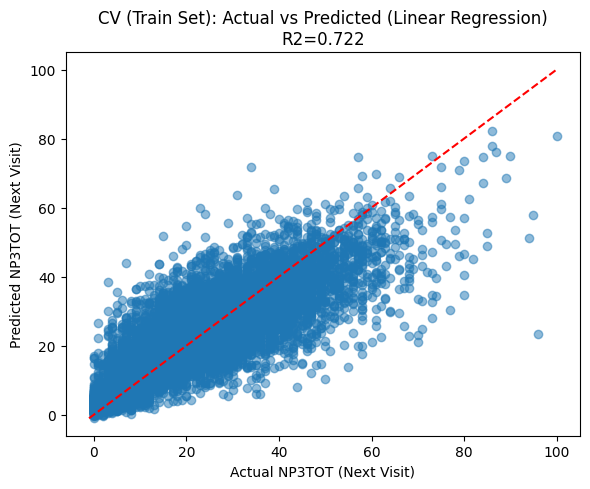

Cross-validating SVR...
SVR: MAE=5.962, RMSE=8.620, R2=0.695


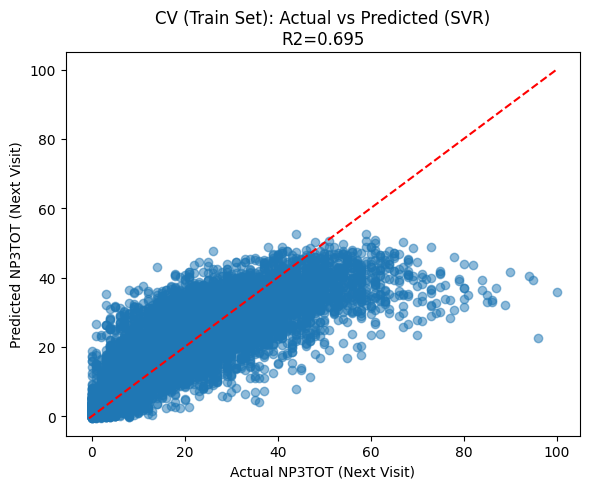

Cross-validating RandomForest Regressor...
RandomForest Regressor: MAE=5.861, RMSE=8.285, R2=0.718


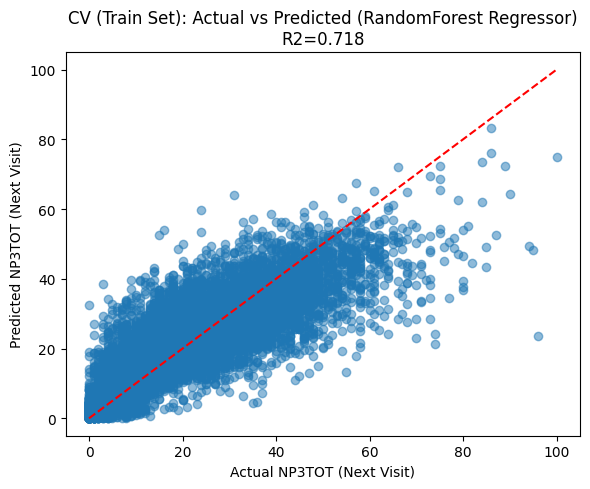

Cross-validating GradientBoosting Regressor...
GradientBoosting Regressor: MAE=5.817, RMSE=8.209, R2=0.723


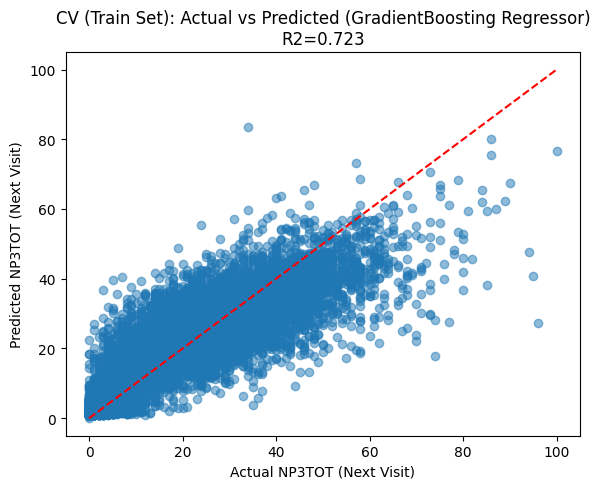

Cross-validating XGBoost...
XGBoost: MAE=6.094, RMSE=8.686, R2=0.690


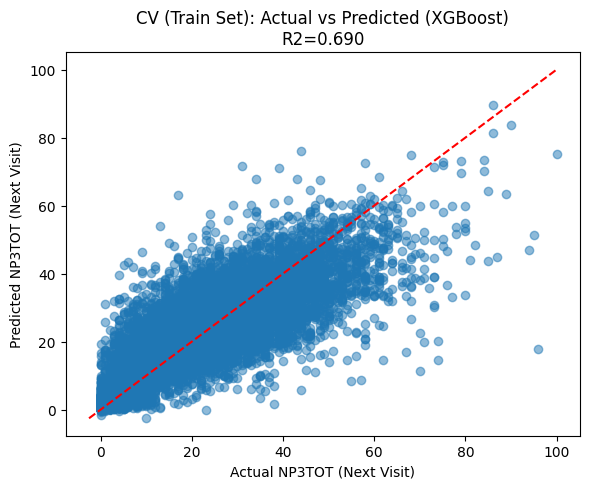

Cross-validating KNeighbors...
KNeighbors: MAE=6.425, RMSE=9.134, R2=0.658


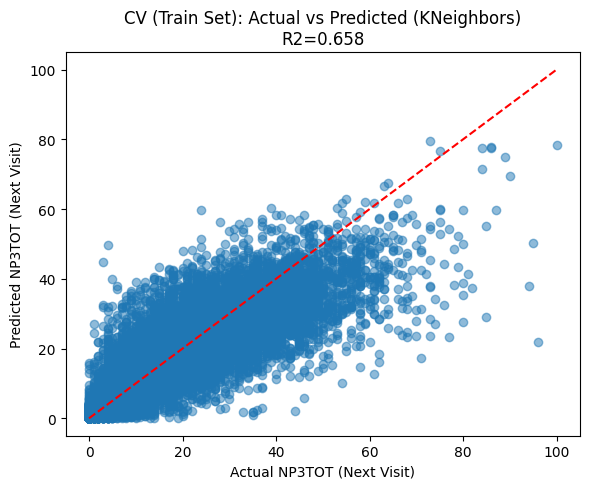

Cross-validating AdaBoostRegressor...
AdaBoostRegressor: MAE=9.392, RMSE=11.138, R2=0.491


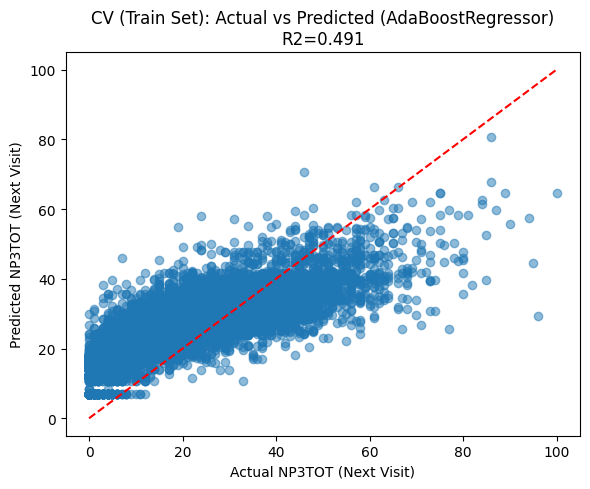

Cross-validating MLP Regressor...
MLP Regressor: MAE=5.966, RMSE=8.404, R2=0.710


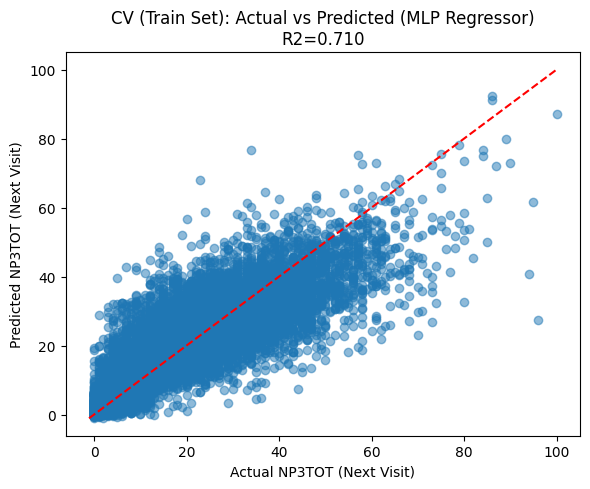


Cross-Validation Performance Summary (on Training Data):
                        Model    MAE    RMSE  R-squared
0           Linear Regression  5.877   8.223      0.722
1                         SVR  5.962   8.620      0.695
2      RandomForest Regressor  5.861   8.285      0.718
3  GradientBoosting Regressor  5.817   8.209      0.723
4                     XGBoost  6.094   8.686      0.690
5                  KNeighbors  6.425   9.134      0.658
6           AdaBoostRegressor  9.392  11.138      0.491
7               MLP Regressor  5.966   8.404      0.710


In [45]:
# Initialize results list for CV
results_cv = []

# Define cross-validation strategy
cv = GroupKFold(n_splits=5) # Use GroupKFold


print("\n--- Evaluating with Cross-Validation (on Training Data) ---")

for name, model in models.items():
    print(f"Cross-validating {name}...")

    # --- MODIFICATION START ---
    # Get cross-validated predictions on the scaled training data (NumPy array)
    y_pred_cv = cross_val_predict(model, X_train_scaled.values, y_train, groups=groups_train, cv=cv) # Use .values
    # --- MODIFICATION END ---

    mae_cv = mean_absolute_error(y_train, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)

    results_cv.append({"Model": name, "MAE": mae_cv, "RMSE": rmse_cv, "R-squared": r2_cv})
    print(f"{name}: MAE={mae_cv:.3f}, RMSE={rmse_cv:.3f}, R2={r2_cv:.3f}")

    # Plot actual vs predicted for CV
    plt.figure(figsize=(6, 5))
    plt.scatter(y_train, y_pred_cv, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"CV (Train Set): Actual vs Predicted ({name})\nR2={r2_cv:.3f}")
    min_val = min(y_train.min(), y_pred_cv.min())
    max_val = max(y_train.max(), y_pred_cv.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()


# Write CV results to a CSV file in the specified directory
# csv_file_cv = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test__cv_lag3.csv"
# try:
#     with open(csv_file_cv, mode='w', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
#         writer.writeheader()
#         writer.writerows(results_cv)
#     print(f"\nCross-validation results written to {csv_file_cv}")
# except IOError as e:
#     print(f"Error writing file {csv_file_cv}: {e}")

# Display CV results as DataFrame
results_cv_df = pd.DataFrame(results_cv)
print("\nCross-Validation Performance Summary (on Training Data):")
print(results_cv_df.round(3))